In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [2]:
# Step 1: Load and preprocess images
def load_images(data_path, img_size=(64, 64)):
    data = []
    labels = []
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path):
            class_label = folder
            class_images = os.listdir(folder_path)[:1500]  # Select the first 1500 images
            for img_name in class_images:
                img_path = os.path.join(folder_path, img_name)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                data.append(img_array)
                labels.append(class_label)
    return np.array(data), labels

In [3]:
from google.colab import drive
drive.mount('/content/drive')
zip_file_path = '/content/drive/MyDrive/archive.zip'

Mounted at /content/drive


In [4]:
import zipfile
extracted_folder_path = '/content/extracted_contents'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [5]:
data_path = "/content/extracted_contents/asl_alphabet_train/asl_alphabet_train"
print(os.listdir(data_path))

['J', 'Y', 'K', 'E', 'Z', 'Q', 'B', 'L', 'I', 'del', 'S', 'O', 'R', 'N', 'space', 'T', 'H', 'V', 'G', 'X', 'F', 'C', 'nothing', 'D', 'W', 'U', 'M', 'P', 'A']


In [6]:
CODES = {"nothing": 0}
def make_labels():
    alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    for i in range(1, 27):
        CODES[alpha[i - 1]] = i

    CODES["del"] = 27
    CODES["space"] = 28
    return CODES

In [7]:
def code_conv(label, codes):
    return codes[label]

In [8]:
def preprocess_labels(labels, codes):
    labels = list(map(lambda x: code_conv(x, codes), labels))
    return to_categorical(labels, num_classes=len(codes))

In [9]:
def normalize_data(data):
    return data.astype('float32') / 255.0

In [10]:
data, labels = load_images(data_path)
codes = make_labels()
labels = preprocess_labels(labels, codes)
data = normalize_data(data)
# Dimensions of the data
print("Data shape:", data.shape)

# Dimensions of the labels
print("Labels shape:", len(labels))

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=42)


Data shape: (43500, 64, 64, 3)
Labels shape: 43500


In [11]:
# Step 3: Load MobileNet pre-trained model
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Dense
from keras.applications import MobileNet
from keras.optimizers import Adam

model = Sequential()
model.add(MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3)))
model.add(GlobalMaxPooling2D())
model.add(Dense(29, activation='softmax'))




17225924/17225924 [==============================] - 0s 0us/step


In [12]:
# Step 4: Compile and train the model

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, batch_size=500, epochs=100, validation_data=(X_val, y_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 2, 2, 1024)        3228864   
 onal)                                                           
                                                                 
 global_max_pooling2d (Glob  (None, 1024)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 29)                29725     
                                                                 
Total params: 3258589 (12.43 MB)
Trainable params: 3236701 (12.35 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________
Epoch 1/100
61/61 [==============================] - 40s 320ms/step - loss: 5.6662 - accuracy: 0.0721 - val_loss: 4.4534 - val_accuracy: 0.0707
E

In [13]:
from google.colab import files

model.save('mobilenet_model.h5')

# Download the model file
files.download('mobilenet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
  # Evaluate the model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

204/204 [==============================] - 2s 8ms/step - loss: 0.0331 - accuracy: 0.9905
Test Loss: 0.03314313665032387
Test Accuracy: 0.9904980659484863


In [15]:
# Dimensions of the data
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

# Dimensions of the labels
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)
print("Test labels shape:", y_test.shape)


Training data shape: (30450, 64, 64, 3)
Validation data shape: (6525, 64, 64, 3)
Test data shape: (6525, 64, 64, 3)
Training labels shape: (30450, 29)
Validation labels shape: (6525, 29)
Test labels shape: (6525, 29)


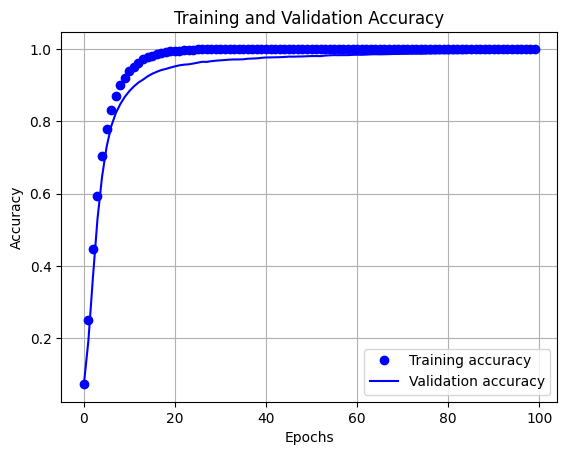

In [16]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy from history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs from 0 to 19
epochs = range(0, 100)  # 0-19 inclusive

# Plot training accuracy as dots and validation accuracy as lines
plt.plot(epochs, training_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


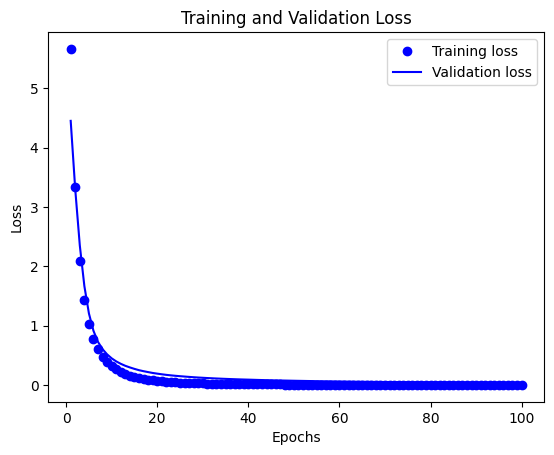

In [17]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, len(training_loss) + 1)

# Plot training loss as dots and validation loss as lines
plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
# Extract training and validation accuracy and loss from history
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

# Get the number of epochs
num_epochs = len(training_accuracy)

# Print the results in percentage
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}:")
    print(f"Training Accuracy: {training_accuracy[epoch] * 100:.2f}%")
    print(f"Training Loss: {training_loss[epoch] * 100:.2f}%")
    print(f"Validation Accuracy: {validation_accuracy[epoch] * 100:.2f}%")
    print(f"Validation Loss: {validation_loss[epoch] * 100:.2f}%")
    print()


Epoch 1:
Training Accuracy: 7.21%
Training Loss: 566.62%
Validation Accuracy: 7.07%
Validation Loss: 445.34%

Epoch 2:
Training Accuracy: 25.09%
Training Loss: 334.11%
Validation Accuracy: 19.25%
Validation Loss: 329.46%

Epoch 3:
Training Accuracy: 44.57%
Training Loss: 209.85%
Validation Accuracy: 36.83%
Validation Loss: 235.25%

Epoch 4:
Training Accuracy: 59.44%
Training Loss: 143.42%
Validation Accuracy: 52.98%
Validation Loss: 166.86%

Epoch 5:
Training Accuracy: 70.42%
Training Loss: 103.19%
Validation Accuracy: 64.61%
Validation Loss: 120.64%

Epoch 6:
Training Accuracy: 77.72%
Training Loss: 78.15%
Validation Accuracy: 72.90%
Validation Loss: 91.31%

Epoch 7:
Training Accuracy: 83.07%
Training Loss: 60.20%
Validation Accuracy: 78.54%
Validation Loss: 72.55%

Epoch 8:
Training Accuracy: 87.00%
Training Loss: 47.79%
Validation Accuracy: 82.18%
Validation Loss: 60.30%

Epoch 9:
Training Accuracy: 89.93%
Training Loss: 38.79%
Validation Accuracy: 84.72%
Validation Loss: 51.57%

Ep

In [19]:
# Extract training and validation accuracy from history
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

# Calculate total training accuracy and loss
total_training_accuracy = sum(training_accuracy) / len(training_accuracy)
total_training_loss = sum(training_loss) / len(training_loss)

# Calculate total validation accuracy and loss
total_validation_accuracy = sum(validation_accuracy) / len(validation_accuracy)
total_validation_loss = sum(validation_loss) / len(validation_loss)

print("Total Training Accuracy:", total_training_accuracy*100)
print("Total Training Loss:", total_training_loss*100)
print("Total Validation Accuracy:", total_validation_accuracy*100)
print("Total Validation Loss:", total_validation_loss*100)


Total Training Accuracy: 96.07770115882158
Total Training Loss: 18.339498316694517
Total Validation Accuracy: 93.5126438587904
Total Validation Loss: 24.597241073846817


204/204 [==============================] - 2s 7ms/step


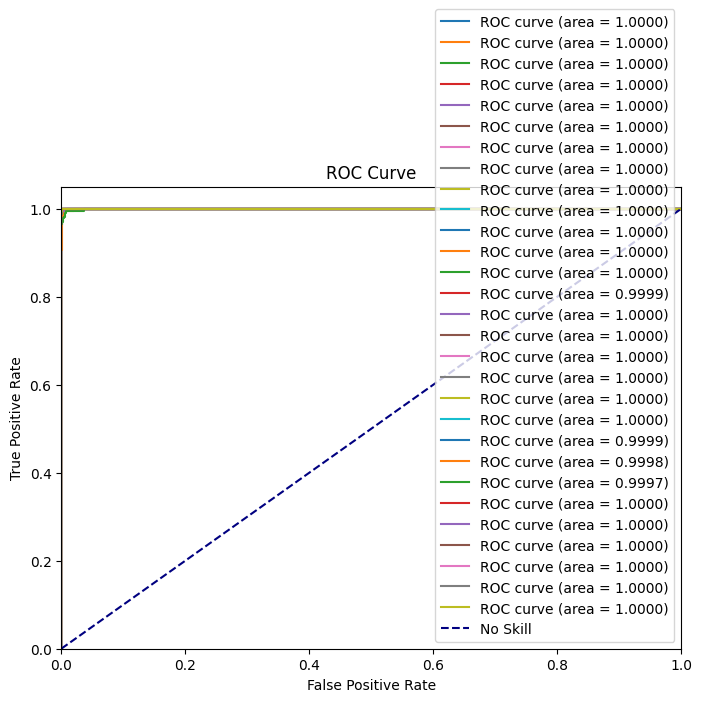

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate predicted probabilities for the test set
y_score = model.predict(X_test)
num_classes=29
# Compute ROC curve and ROC area for each label
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):  # Assuming num_classes is the number of classes in your problem
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each label
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.4f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [21]:
from sklearn.metrics import classification_report

# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Predict classes for test set
# y_pred = model.predict_classes(X_test)

# Convert one-hot encoded labels back to original labels
y_true = [np.argmax(label) for label in y_test]

# Generate classification report
report = classification_report(y_true, y_pred)

# Print classification report
print("Classification Report:")
print(report)


204/204 [==============================] - 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       227
           1       0.99      0.99      0.99       229
           2       1.00      1.00      1.00       206
           3       1.00      1.00      1.00       230
           4       0.99      1.00      0.99       205
           5       1.00      1.00      1.00       210
           6       1.00      0.99      1.00       214
           7       1.00      1.00      1.00       209
           8       1.00      1.00      1.00       242
           9       1.00      0.98      0.99       219
          10       1.00      1.00      1.00       248
          11       0.98      1.00      0.99       241
          12       1.00      0.99      0.99       240
          13       0.97      0.99      0.98       245
          14       0.99      0.99      0.99       235
          15       0.99      0.98      0.99       206
   

204/204 [==============================] - 1s 5ms/step


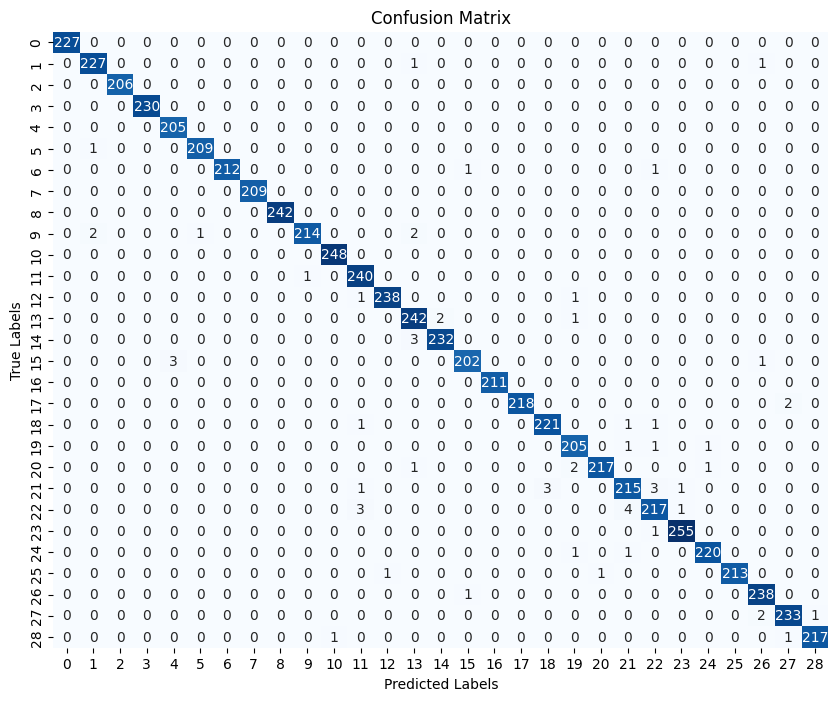

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
# Convert one-hot encoded labels back to original labels
y_true = [np.argmax(label) for label in y_test]

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [23]:
def get_model_size_mb(model):
    total_size_bytes = 0
    for layer in model.layers:
        for weight in layer.weights:
            total_size_bytes += weight.numpy().nbytes
    total_size_mb = total_size_bytes / (1024 * 1024)
    return total_size_mb

# Get the size of the model in megabytes
model_size_mb = get_model_size_mb(model)
print("Model size: {:.2f} MB".format(model_size_mb))


Model size: 12.43 MB


In [24]:
import os

# Get the path to your .h5 file
model_file_path = 'mobilenet_model.h5'  # Replace 'my_model.h5' with the path to your .h5 file

# Get the size of the .h5 file in bytes
model_file_size_bytes = os.path.getsize(model_file_path)

# Convert the size to megabytes
model_file_size_mb = model_file_size_bytes / (1024 * 1024)

print("Model file size: {:.2f} MB".format(model_file_size_mb))


Model file size: 37.47 MB


In [25]:
# Evaluate the model on the test or validation dataset
evaluation = model.evaluate(X_test, y_test)

# Print the loss value and all available metrics
print("Loss:", evaluation[0])
if len(model.metrics_names) > 1:
    for i, metric in enumerate(model.metrics_names[1:]):
        print(f"{metric.capitalize()}: {evaluation[i+1]}")

204/204 [==============================] - 1s 7ms/step - loss: 0.0331 - accuracy: 0.9905
Loss: 0.03314313665032387
Accuracy: 0.9904980659484863


In [26]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

model_tf = tf.keras.models.load_model("mobilenet_model.h5")

# Perform inference on X_test
predictions = model_tf.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predicted_labels == true_labels)
print(predicted_labels,true_labels)
print("Accuracy of tenserflow model:", accuracy*100)

204/204 [==============================] - 2s 6ms/step
[ 7  8 23 ...  1 10 10] [ 7  8 23 ...  1 10 10]
Accuracy of tenserflow model: 99.04980842911877


In [27]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_tf)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()


# Save the converted model to a .tflite file
with open("optimized_mobilenet.tflite", "wb") as f:
    f.write(tflite_model)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="optimized_mobilenet.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Perform inference on X_test
predictions = []
for image in X_test:
    # Preprocess input image if necessary
    input_data = np.expand_dims(image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()

    # Get the output tensor and post-process if necessary
    output_data = interpreter.get_tensor(output_details["index"])
    predictions.append(output_data)

# Convert predictions to labels
#prediction_labels = np.argmax(predictions, axis=1)

# Convert y_test to labels
true_labels = np.argmax(y_test, axis=1)
print(predictions,true_labels)
# Calculate accuracy
accuracy = np.mean(predictions == true_labels)

print("Accuracy of quantized tenserflowlite model:", accuracy)

# Get the path to your .h5 file
model_file_path = 'optimized_mobilenet.tflite'  # Replace 'my_model.h5' with the path to your .h5 file
model_file_size_bytes = os.path.getsize(model_file_path)
model_file_size_mb = model_file_size_bytes / (1024 * 1024)
print("Model file size: {:.2f} MB".format(model_file_size_mb))



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ValueError: operands could not be broadcast together with shapes (6525,) (6525,1,29) 